<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Cleaning-and-Transformation:" data-toc-modified-id="Data-Cleaning-and-Transformation:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Cleaning and Transformation:</a></span><ul class="toc-item"><li><span><a href="#Translate-column-names-to-English:" data-toc-modified-id="Translate-column-names-to-English:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Translate column names to English:</a></span></li><li><span><a href="#Create-a-column-specifying-type-of-offer:-For-Sale-or-For-Rent:" data-toc-modified-id="Create-a-column-specifying-type-of-offer:-For-Sale-or-For-Rent:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create a column specifying type of offer: For Sale or For Rent:</a></span></li><li><span><a href="#Create-a-new-dataframe-before-I-start-to-do-more-changes" data-toc-modified-id="Create-a-new-dataframe-before-I-start-to-do-more-changes-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create a new dataframe before I start to do more changes</a></span></li><li><span><a href="#Remove-unnecessary-columns-with-website-link-and-information-about-loans" data-toc-modified-id="Remove-unnecessary-columns-with-website-link-and-information-about-loans-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Remove unnecessary columns with website link and information about loans</a></span></li><li><span><a href="#Create-a-column-with-city-names-using-polish-characters" data-toc-modified-id="Create-a-column-with-city-names-using-polish-characters-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Create a column with city names using polish characters</a></span></li><li><span><a href="#Add-districts" data-toc-modified-id="Add-districts-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Add districts</a></span></li><li><span><a href="#Is-there-possibility-to-negotiate-a-price?" data-toc-modified-id="Is-there-possibility-to-negotiate-a-price?-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Is there possibility to negotiate a price?</a></span></li><li><span><a href="#Create-a-function-which-remove-unnecessary-text-from-chosen-column-and-keep-just-the-first-value" data-toc-modified-id="Create-a-function-which-remove-unnecessary-text-from-chosen-column-and-keep-just-the-first-value-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Create a function which remove unnecessary text from chosen column and keep just the first value</a></span></li><li><span><a href="#Remove-empty-spaces-in-the-first-two-columns" data-toc-modified-id="Remove-empty-spaces-in-the-first-two-columns-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Remove empty spaces in the first two columns</a></span></li><li><span><a href="#Rename-values-in-a-chosen-columns---from-object-to-integer" data-toc-modified-id="Rename-values-in-a-chosen-columns---from-object-to-integer-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Rename values in a chosen columns - from object to integer</a></span></li></ul></li><li><span><a href="#Data-Preparation:" data-toc-modified-id="Data-Preparation:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preparation:</a></span><ul class="toc-item"><li><span><a href="#Create-two-separate-tables-(for-rent-/-for-sale):" data-toc-modified-id="Create-two-separate-tables-(for-rent-/-for-sale):-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create two separate tables (for rent / for sale):</a></span></li><li><span><a href="#Remove-unnecessary-columns" data-toc-modified-id="Remove-unnecessary-columns-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Remove unnecessary columns</a></span></li><li><span><a href="#Change-data-types---'object'-to-'float'---for-columns-with-numbers." data-toc-modified-id="Change-data-types---'object'-to-'float'---for-columns-with-numbers.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Change data types - 'object' to 'float' - for columns with numbers.</a></span></li><li><span><a href="#Create-final-price-for-rent-properties" data-toc-modified-id="Create-final-price-for-rent-properties-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Create final price for rent properties</a></span></li><li><span><a href="#Choosing-types-of-building-we-use-in-the-analysis" data-toc-modified-id="Choosing-types-of-building-we-use-in-the-analysis-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Choosing types of building we use in the analysis</a></span></li><li><span><a href="#Price-checking:" data-toc-modified-id="Price-checking:-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Price checking:</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Map-with-our-cities-(folium-library)" data-toc-modified-id="Map-with-our-cities-(folium-library)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Map with our cities (folium library)</a></span></li><li><span><a href="#Distance-between-cities" data-toc-modified-id="Distance-between-cities-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Distance between cities</a></span></li><li><span><a href="#Profitability-calculation" data-toc-modified-id="Profitability-calculation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Profitability calculation</a></span></li><li><span><a href="#Summary:" data-toc-modified-id="Summary:-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Summary:</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
url = 'https://raw.githubusercontent.com/mborycki/Silesian_Real_Estate_Market/master'
olx_link = f'{url}/OLX_Offers.csv'
location_list = f'{url}/locations.txt'

In [3]:
olx_df = pd.read_csv(olx_link)

In [4]:
olx_df.columns

Index(['Cena', 'Cena za m²', 'Czynsz (dodatkowo)', 'Finanse', 'Liczba pokoi',
       'Miejsce', 'Oferta od', 'Powierzchnia', 'Poziom', 'Rodzaj zabudowy',
       'Rynek', 'Umeblowane', 'Miasto'],
      dtype='object')

In [5]:
olx_df.shape

(2121, 13)

In [6]:
olx_df.head()

,Cena,Cena za m²,Czynsz (dodatkowo),Finanse,Liczba pokoi,Miejsce,Oferta od,Powierzchnia,Poziom,Rodzaj zabudowy,Rynek,Umeblowane,Miasto
0,2 000 zł,NaN,1 zł,NaN,3 pokoje,"Rybnik, Śląskie",Osoby prywatnej,69 m²,1,Apartamentowiec,NaN,Nie,rybnik
1,280 000 złDo negocjacji,3684.21 zł/m²,NaN,Otwórz konto w promocji >>,4 i więcej,"Rybnik, Śląskie",Biuro / Deweloper,76 m²,1,Blok,Wtórny,Nie,rybnik
2,1 800 złDo negocjacji,NaN,100 zł,NaN,3 pokoje,"Rybnik, Śląskie",Biuro / Deweloper,100 m²,Parter,Dom wolnostojący,NaN,Tak,rybnik
3,1 300 złDo negocjacji,NaN,600 zł,NaN,2 pokoje,"Rybnik, Śląskie",Osoby prywatnej,50 m²,1,Blok,NaN,Tak,rybnik
4,2 200 zł,NaN,1 zł,NaN,2 pokoje,"Rybnik, Śląskie",Osoby prywatnej,66 m²,4,Blok,NaN,Tak,rybnik


## Data Cleaning and Transformation:

### Translate column names to English:

In [7]:
olx_df.rename(columns={
    'Cena': 'Price',
    'Cena za m²': 'PriceSqM',
    'Czynsz (dodatkowo)': 'MonthlyRent',
    'Finanse': 'Finances',
    'Liczba pokoi': 'Bedrooms',
    'Miejsce': 'Place',
    'Oferta od': 'Advert_Owner',
    'Powierzchnia': 'SqM',
    'Poziom': 'Floor',
    'Rodzaj zabudowy': 'BuildingType',
    'Rynek': 'Market',
    'Umeblowane': 'Furnishings',
    'Miasto': 'City'
},
              inplace=True)

In [8]:
olx_df.head(2)

,Price,PriceSqM,MonthlyRent,Finances,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,City
0,2 000 zł,NaN,1 zł,NaN,3 pokoje,"Rybnik, Śląskie",Osoby prywatnej,69 m²,1,Apartamentowiec,NaN,Nie,rybnik
1,280 000 złDo negocjacji,3684.21 zł/m²,NaN,Otwórz konto w promocji >>,4 i więcej,"Rybnik, Śląskie",Biuro / Deweloper,76 m²,1,Blok,Wtórny,Nie,rybnik


In [9]:
olx_df.Advert_Owner.replace(['Osoby prywatnej', 'Biuro / Deweloper'],
                            ['Developer', 'Private'],
                            inplace=True)
olx_df.Advert_Owner.unique()

array(['Developer', 'Private'], dtype=object)

In [10]:
olx_df.BuildingType.replace([
    'Apartamentowiec', 'Blok', 'Dom wolnostojący', 'Kamienica', 'Pozostałe',
    'Loft', 'Szeregowiec'
], ['Apartment', 'Flat', 'House', 'Tenement', 'Other', 'Loft', 'Townhouse'],
                            inplace=True)
olx_df.BuildingType.unique()

array(['Apartment', 'Flat', 'House', 'Tenement', 'Other', 'Loft',
       'Townhouse'], dtype=object)

In [11]:
olx_df.Market.replace(['Wtórny', 'Pierwotny'], ['After', 'Primary'],
                      inplace=True)
olx_df.Market.unique()

array([nan, 'After', 'Primary'], dtype=object)

In [12]:
olx_df.head(2)

,Price,PriceSqM,MonthlyRent,Finances,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,City
0,2 000 zł,NaN,1 zł,NaN,3 pokoje,"Rybnik, Śląskie",Developer,69 m²,1,Apartment,NaN,Nie,rybnik
1,280 000 złDo negocjacji,3684.21 zł/m²,NaN,Otwórz konto w promocji >>,4 i więcej,"Rybnik, Śląskie",Private,76 m²,1,Flat,After,Nie,rybnik


### Create a column specifying type of offer: For Sale or For Rent:

In [13]:
olx_df['OfferType'] = np.where(olx_df['MonthlyRent'].isnull(), 'For_Sale',
                               'For_Rent')

### Create a new dataframe before I start to do more changes

In [14]:
olx_table = olx_df.copy()

### Remove unnecessary columns with website link and information about loans 

In [15]:
olx_table.drop(columns={'Finances'}, axis=1, inplace=True)

In [16]:
olx_table.head(2)

,Price,PriceSqM,MonthlyRent,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,City,OfferType
0,2 000 zł,NaN,1 zł,3 pokoje,"Rybnik, Śląskie",Developer,69 m²,1,Apartment,NaN,Nie,rybnik,For_Rent
1,280 000 złDo negocjacji,3684.21 zł/m²,NaN,4 i więcej,"Rybnik, Śląskie",Private,76 m²,1,Flat,After,Nie,rybnik,For_Sale


### Create a column with city names using polish characters 

In [17]:
olx_table['City2'] = olx_table['Place'].str.split(',').str[0]

In [18]:
olx_table.head(2)

,Price,PriceSqM,MonthlyRent,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,City,OfferType,City2
0,2 000 zł,NaN,1 zł,3 pokoje,"Rybnik, Śląskie",Developer,69 m²,1,Apartment,NaN,Nie,rybnik,For_Rent,Rybnik
1,280 000 złDo negocjacji,3684.21 zł/m²,NaN,4 i więcej,"Rybnik, Śląskie",Private,76 m²,1,Flat,After,Nie,rybnik,For_Sale,Rybnik


In [19]:
olx_table.City2.unique()

array(['Rybnik', 'Chorzów', 'Tychy', 'no data', 'Mysłowice', 'Mikołów',
       'Tarnowskie Góry', 'Gliwice', 'Zabrze', 'Ruda Śląska', 'Knurów',
       'Świętochłowice', 'Bytom', 'Żory', 'Wodzisław Śląski', 'Katowice'],
      dtype=object)

In [20]:
# We have some 'no data' records so in that cases let's use city names used in during scraping process (with capitalize func)
olx_table['City2'] = np.where(olx_table['City2'] == 'no data',
                              olx_table['City'].str.capitalize(),
                              olx_table['City2'])

In [21]:
olx_table.City2.unique()

array(['Rybnik', 'Chorzów', 'Tychy', 'Mysłowice', 'Mikołów',
       'Tarnowskie Góry', 'Gliwice', 'Zabrze', 'Ruda Śląska', 'Knurów',
       'Świętochłowice', 'Bytom', 'Żory', 'Wodzisław Śląski', 'Katowice'],
      dtype=object)

In [22]:
olx_table.drop(columns={'City'}, inplace=True)

In [23]:
olx_table.rename(columns={'City2': 'City'}, inplace=True)

### Add districts

As it is one of the biggest reason of having different price in the same city  

In [24]:
def DistrictA(tbl):
    return tbl['Place'].str.split().str[-1]

In [25]:
def DistrictB(tbl):
    return tbl['Place'].str.split(
        ',').str[0] + ', ' + tbl['Place'].str.split().str[-1]

In [26]:
olx_table['District'] = DistrictA(olx_table)

In [27]:
olx_table['District'] = np.where(olx_table['District'] == 'Śląskie',
                                 olx_table.City, olx_table.District)

In [28]:
olx_table['District'] = np.where(olx_table['District'] == olx_table.City,
                                 olx_table.City, DistrictB(olx_table))
olx_table['District'] = np.where(olx_table['District'] == 'no data, data',
                                 olx_table['City'], olx_table['District'])

In [29]:
olx_table.District.sort_values().unique()

array(['Bytom', 'Chorzów', 'Gliwice', 'Gliwice, Bojków',
       'Gliwice, Kopernika', 'Gliwice, Ostropa', 'Gliwice, Pokoju',
       'Gliwice, Politechnika', 'Gliwice, Polskiego', 'Gliwice, Sikornik',
       'Gliwice, Sośnica', 'Gliwice, Szobiszowice', 'Gliwice, Trynek',
       'Gliwice, Wieś', 'Gliwice, Zabrska', 'Gliwice, Zatorze',
       'Gliwice, Łabędy', 'Gliwice, Śródmieście', 'Katowice, Bogucice',
       'Katowice, Dąb', 'Katowice, Giszowiec',
       'Katowice, Janów-Nikiszowiec', 'Katowice, Kostuchna',
       'Katowice, Koszutka', 'Katowice, Ligota-Panewniki',
       'Katowice, Mała', 'Katowice, Murcki',
       'Katowice, Paderewskiego-Muchowiec',
       'Katowice, Piotrowice-Ochojec', 'Katowice, Podlesie',
       'Katowice, Szopienice-Burowiec', 'Katowice, Tysiąclecia',
       'Katowice, Wełnowiec-Józefowiec', 'Katowice, Witosa',
       'Katowice, Zach.', 'Katowice, Zawodzie', 'Katowice, Załęże',
       'Katowice, Zgrzebioka', 'Katowice, Śródmieście', 'Knurów',
       'Mikołów,

### Is there possibility to negotiate a price?

In [30]:
olx_table['Negotiating'] = np.where(
    olx_table.Price.str.contains('Do negocjacji'), 1, 0)

In [31]:
olx_table.head()

,Price,PriceSqM,MonthlyRent,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,OfferType,City,District,Negotiating
0,2 000 zł,NaN,1 zł,3 pokoje,"Rybnik, Śląskie",Developer,69 m²,1,Apartment,NaN,Nie,For_Rent,Rybnik,Rybnik,0
1,280 000 złDo negocjacji,3684.21 zł/m²,NaN,4 i więcej,"Rybnik, Śląskie",Private,76 m²,1,Flat,After,Nie,For_Sale,Rybnik,Rybnik,1
2,1 800 złDo negocjacji,NaN,100 zł,3 pokoje,"Rybnik, Śląskie",Private,100 m²,Parter,House,NaN,Tak,For_Rent,Rybnik,Rybnik,1
3,1 300 złDo negocjacji,NaN,600 zł,2 pokoje,"Rybnik, Śląskie",Developer,50 m²,1,Flat,NaN,Tak,For_Rent,Rybnik,Rybnik,1
4,2 200 zł,NaN,1 zł,2 pokoje,"Rybnik, Śląskie",Developer,66 m²,4,Flat,NaN,Tak,For_Rent,Rybnik,Rybnik,0


### Create a function which remove unnecessary text from chosen column and keep just the first value

But first we need to remove null values from chosen columns

In [32]:
olx_table.isnull().sum()

Price              0
PriceSqM        1380
MonthlyRent      831
Bedrooms           0
Place              0
Advert_Owner       0
SqM                0
Floor             51
BuildingType       0
Market          1380
Furnishings        0
OfferType          0
City               0
District           0
Negotiating        0
dtype: int64

In [33]:
olx_table['PriceSqM'] = olx_table['PriceSqM'].replace(np.nan, '0  zł/m²')

In [34]:
olx_table['MonthlyRent'] = olx_table['MonthlyRent'].replace(np.nan, '0  zł')

In [35]:
olx_table.head(2)

,Price,PriceSqM,MonthlyRent,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,OfferType,City,District,Negotiating
0,2 000 zł,0 zł/m²,1 zł,3 pokoje,"Rybnik, Śląskie",Developer,69 m²,1,Apartment,NaN,Nie,For_Rent,Rybnik,Rybnik,0
1,280 000 złDo negocjacji,3684.21 zł/m²,0 zł,4 i więcej,"Rybnik, Śląskie",Private,76 m²,1,Flat,After,Nie,For_Sale,Rybnik,Rybnik,1


In [36]:
def remove_str(x):
    token1 = x.split(' złDo negocjacji')  # Price
    token2 = x.split(' zł')  # Price / MonthlyRent
    token3 = x.split(' zł/m²')  # PriceSqM
    token4 = x.split(' m²')  # SqM
    if len(token1) == 2:
        return (str(token1[0]))
    elif len(token2) == 2:
        return (str(token2[0]))
    elif len(token3) == 2:
        return (str(token3[0]))
    elif len(token4) == 2:
        return (str(token4[0]))
    try:
        return str(x)
    except:
        return False

In [37]:
olx_table['Price'] = olx_table['Price'].apply(remove_str)

In [38]:
olx_table['PriceSqM'] = olx_table['PriceSqM'].apply(remove_str)

In [39]:
olx_table['SqM'] = olx_table['SqM'].apply(remove_str)

In [40]:
olx_table['MonthlyRent'] = olx_table['MonthlyRent'].apply(remove_str)

In [41]:
olx_table.head(2)

,Price,PriceSqM,MonthlyRent,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,OfferType,City,District,Negotiating
0,2 000,0,1,3 pokoje,"Rybnik, Śląskie",Developer,69,1,Apartment,NaN,Nie,For_Rent,Rybnik,Rybnik,0
1,280 000,3684.21,0,4 i więcej,"Rybnik, Śląskie",Private,76,1,Flat,After,Nie,For_Sale,Rybnik,Rybnik,1


### Remove empty spaces in the first two columns

In [42]:
olx_table.iloc[0, 0]

'2 000'

In [43]:
olx_table['Price'] = olx_table['Price'].str.replace(' ', '')
olx_table['PriceSqM'] = olx_table['PriceSqM'].str.replace(' ', '')
olx_table.iloc[0, 0]

'2000'

In [44]:
olx_table.head(2)

,Price,PriceSqM,MonthlyRent,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,OfferType,City,District,Negotiating
0,2000,0,1,3 pokoje,"Rybnik, Śląskie",Developer,69,1,Apartment,NaN,Nie,For_Rent,Rybnik,Rybnik,0
1,280000,3684.21,0,4 i więcej,"Rybnik, Śląskie",Private,76,1,Flat,After,Nie,For_Sale,Rybnik,Rybnik,1


### Rename values in a chosen columns - from object to integer

In [45]:
olx_table.Bedrooms.unique()

array(['3 pokoje', '4 i więcej', '2 pokoje', 'Kawalerka', '1 pokój'],
      dtype=object)

In [46]:
olx_table.groupby('Bedrooms')['Bedrooms'].count()

Bedrooms
1 pokój       100
2 pokoje      950
3 pokoje      548
4 i więcej    115
Kawalerka     408
Name: Bedrooms, dtype: int64

In [47]:
def rooms_number(x):
    if x == 'Kawalerka' or x == '1 pokój':
        return 1
    elif x == '2 pokoje':
        return 2
    elif x == '3 pokoje':
        return 3
    else:
        return 4

In [48]:
olx_table['Bedrooms'] = olx_table['Bedrooms'].apply(rooms_number)

In [49]:
olx_table.groupby('Bedrooms')['Bedrooms'].count()

Bedrooms
1    508
2    950
3    548
4    115
Name: Bedrooms, dtype: int64

In [50]:
olx_table.Floor.unique()  # we have some object in here

array(['1', 'Parter', '4', '2', '7', nan, '3', '5', '8', '6', '10',
       'Powyżej 10', '9', 'Poddasze'], dtype=object)

In [51]:
olx_table.groupby('Floor')['Floor'].count()

Floor
1             521
10             42
2             427
3             309
4             228
5              36
6              40
7              31
8              19
9              32
Parter        363
Poddasze        4
Powyżej 10     18
Name: Floor, dtype: int64

I am not interested in: Attic (Poddasze), floor > 10. So I removed records with those floors and with null. Ground Floor (Parter) has been renamed to 0 

In [52]:
olx_table.drop(olx_table[(olx_table.Floor == 'Poddasze') |
                         (olx_table.Floor == 'Powyżej 10')].index,
               axis=0,
               inplace=True)

In [53]:
olx_table.dropna(subset=['Floor'], inplace=True)

In [54]:
olx_table['Floor'] = olx_table.Floor.replace('Parter', '0')

In [55]:
olx_table['Floor'] = olx_table['Floor'].astype(int)

In [56]:
olx_table.groupby('Floor')['Floor'].count()

Floor
0     363
1     521
2     427
3     309
4     228
5      36
6      40
7      31
8      19
9      32
10     42
Name: Floor, dtype: int64

In [57]:
olx_table['Furnishings'] = np.where(olx_table.Furnishings == 'Tak', 1, 0)

In [58]:
olx_table.head()

,Price,PriceSqM,MonthlyRent,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,OfferType,City,District,Negotiating
0,2000,0,1,3,"Rybnik, Śląskie",Developer,69,1,Apartment,NaN,0,For_Rent,Rybnik,Rybnik,0
1,280000,3684.21,0,4,"Rybnik, Śląskie",Private,76,1,Flat,After,0,For_Sale,Rybnik,Rybnik,1
2,1800,0,100,3,"Rybnik, Śląskie",Private,100,0,House,NaN,1,For_Rent,Rybnik,Rybnik,1
3,1300,0,600,2,"Rybnik, Śląskie",Developer,50,1,Flat,NaN,1,For_Rent,Rybnik,Rybnik,1
4,2200,0,1,2,"Rybnik, Śląskie",Developer,66,4,Flat,NaN,1,For_Rent,Rybnik,Rybnik,0


## Data Preparation:

### Create two separate tables (for rent / for sale):

In [59]:
df_rent = olx_table[olx_table.OfferType == 'For_Rent'].copy()
df_sale = olx_table[olx_table.OfferType == 'For_Sale'].copy()

### Remove unnecessary columns

In [60]:
df_sale.head(2)

,Price,PriceSqM,MonthlyRent,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,OfferType,City,District,Negotiating
1,280000,3684.21,0,4,"Rybnik, Śląskie",Private,76,1,Flat,After,0,For_Sale,Rybnik,Rybnik,1
5,187000,4794.87,0,2,"Rybnik, Śląskie",Developer,39,0,Flat,After,1,For_Sale,Rybnik,Rybnik,1


In [61]:
df_rent.head(2)

,Price,PriceSqM,MonthlyRent,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,OfferType,City,District,Negotiating
0,2000,0,1,3,"Rybnik, Śląskie",Developer,69,1,Apartment,NaN,0,For_Rent,Rybnik,Rybnik,0
2,1800,0,100,3,"Rybnik, Śląskie",Private,100,0,House,NaN,1,For_Rent,Rybnik,Rybnik,1


In [62]:
df_sale.drop(columns={'MonthlyRent', 'OfferType'},
             axis='columns',
             inplace=True)

In [63]:
df_rent.drop(columns={'PriceSqM', 'Market', 'OfferType'},
             axis='columns',
             inplace=True)

### Change data types - 'object' to 'float' - for columns with numbers.

In [64]:
def is_float(x):
    try:
        return float(x)
    except:
        return False

In [65]:
def RemoveFalse(df, col):
    return df.drop(df[df[col] == False].index, inplace=True)

**For Sale:**

In [66]:
df_sale.dtypes

Price           object
PriceSqM        object
Bedrooms         int64
Place           object
Advert_Owner    object
SqM             object
Floor            int32
BuildingType    object
Market          object
Furnishings      int32
City            object
District        object
Negotiating      int32
dtype: object

In [67]:
df_sale.shape

(810, 13)

In [68]:
df_sale['Price'] = df_sale['Price'].apply(lambda x: x.replace(',', '.')).apply(
    is_float)
print(
    f'{len(df_sale[df_sale.Price==False])} "False" records before remove them \n'
)
RemoveFalse(df_sale, 'Price')
df_sale['Price'] = df_sale['Price'].apply(is_float)
print(f'{len(df_sale[df_sale.Price==False])} "False" records now')

86 "False" records before remove them 

0 "False" records now


In [69]:
df_sale['PriceSqM'] = df_sale['PriceSqM'].apply(
    lambda x: x.replace(',', '.')).apply(is_float)
print(
    f'{len(df_sale[df_sale.PriceSqM==False])} "False" records before remove them \n'
)
RemoveFalse(df_sale, 'PriceSqM')
df_sale['PriceSqM'] = df_sale['PriceSqM'].apply(is_float)
print(f'{len(df_sale[df_sale.PriceSqM==False])} "False" records now')

0 "False" records before remove them 

0 "False" records now


In [70]:
df_sale['SqM'] = df_sale['SqM'].apply(lambda x: x.replace(',', '.')).apply(
    is_float)
print(
    f'{len(df_sale[df_sale.SqM==False])} "False" records before remove them \n'
)
RemoveFalse(df_sale, 'SqM')
df_sale['SqM'] = df_sale['SqM'].apply(is_float)
print(f'{len(df_sale[df_sale.SqM==False])} "False" records now')

1 "False" records before remove them 

0 "False" records now


In [71]:
df_sale.dtypes

Price           float64
PriceSqM        float64
Bedrooms          int64
Place            object
Advert_Owner     object
SqM             float64
Floor             int32
BuildingType     object
Market           object
Furnishings       int32
City             object
District         object
Negotiating       int32
dtype: object

In [72]:
df_sale.shape

(723, 13)

In [73]:
df_sale.head()

,Price,PriceSqM,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Market,Furnishings,City,District,Negotiating
1,280000.0,3684.21,4,"Rybnik, Śląskie",Private,76.0,1,Flat,After,0,Rybnik,Rybnik,1
5,187000.0,4794.87,2,"Rybnik, Śląskie",Developer,39.0,0,Flat,After,1,Rybnik,Rybnik,1
11,425000.0,4250.00,3,"Rybnik, Śląskie",Private,100.0,1,Apartment,Primary,0,Rybnik,Rybnik,1
12,189000.0,3417.72,3,"Rybnik, Śląskie",Developer,55.3,4,Flat,Primary,1,Rybnik,Rybnik,0
16,143000.0,3575.00,2,"Rybnik, Śląskie",Developer,40.0,0,Flat,After,0,Rybnik,Rybnik,1


In [74]:
df_sale.describe()

,Price,PriceSqM,Bedrooms,SqM,Floor,Furnishings,Negotiating
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,224293.087137,4269.816584,2.438451,53.532116,2.396957,0.507607,0.578147
std,91820.772895,1306.093759,0.805118,17.719590,2.240113,0.500288,0.494197
min,10000.000000,192.310000,1.000000,17.180000,0.000000,0.000000,0.000000
25%,160000.000000,3467.405000,2.000000,40.000000,1.000000,0.000000,0.000000
50%,209000.000000,4102.560000,2.000000,51.500000,2.000000,1.000000,1.000000
75%,266866.000000,5000.000000,3.000000,62.080000,4.000000,1.000000,1.000000
max,870000.000000,10353.960000,4.000000,163.000000,10.000000,1.000000,1.000000


**For Rent:**

In [75]:
df_rent.dtypes

Price           object
MonthlyRent     object
Bedrooms         int64
Place           object
Advert_Owner    object
SqM             object
Floor            int32
BuildingType    object
Furnishings      int32
City            object
District        object
Negotiating      int32
dtype: object

In [76]:
df_rent.shape

(1238, 12)

In [77]:
df_rent['Price'] = df_rent['Price'].apply(lambda x: x.replace(',', '.')).apply(
    is_float)
print(
    f'{len(df_rent[df_rent.Price==False])} "False" records before remove them \n'
)
RemoveFalse(df_rent, 'Price')
df_rent['Price'] = df_rent['Price'].apply(is_float)
print(f'{len(df_rent[df_rent.Price==False])} "False" records now')

0 "False" records before remove them 

0 "False" records now


In [78]:
df_rent['MonthlyRent'] = df_rent['MonthlyRent'].apply(
    lambda x: x.replace(',', '.')).apply(is_float)
print(
    f'{len(df_rent[df_rent.MonthlyRent==False])} "False" records before remove them \n'
)
RemoveFalse(df_rent, 'MonthlyRent')
df_rent['MonthlyRent'] = df_rent['MonthlyRent'].apply(is_float)
print(f'{len(df_rent[df_rent.MonthlyRent==False])} "False" records now')

54 "False" records before remove them 

0 "False" records now


In [79]:
df_rent['SqM'] = df_rent['SqM'].apply(lambda x: x.replace(',', '.')).apply(
    is_float)
print(
    f'{len(df_rent[df_rent.SqM==False])} "False" records before remove them \n'
)
RemoveFalse(df_rent, 'SqM')
df_rent['SqM'] = df_rent['SqM'].apply(is_float)
print(f'{len(df_rent[df_rent.SqM==False])} "False" records now')

0 "False" records before remove them 

0 "False" records now


In [80]:
df_rent.dtypes

Price           float64
MonthlyRent     float64
Bedrooms          int64
Place            object
Advert_Owner     object
SqM             float64
Floor             int32
BuildingType     object
Furnishings       int32
City             object
District         object
Negotiating       int32
dtype: object

In [81]:
df_rent.shape

(1184, 12)

### Create final price for rent properties

Some offers already contain rent costs in rental price, and some not. So, it is better to summarize these costs as we will pay total price (rental price + additional rent). 

In [82]:
df_rent['MonthlyPrice'] = np.where(df_rent.MonthlyRent > 1,
                                   df_rent.MonthlyRent + df_rent.Price,
                                   df_rent.Price)

In [83]:
df_rent['PriceSqM'] = df_rent.MonthlyPrice / df_rent.SqM

In [84]:
df_rent.drop(columns={'Price', 'MonthlyRent'}, inplace=True)

In [85]:
df_rent.head()

,Bedrooms,Place,Advert_Owner,SqM,Floor,BuildingType,Furnishings,City,District,Negotiating,MonthlyPrice,PriceSqM
0,3,"Rybnik, Śląskie",Developer,69.0,1,Apartment,0,Rybnik,Rybnik,0,2000.0,28.985507
2,3,"Rybnik, Śląskie",Private,100.0,0,House,1,Rybnik,Rybnik,1,1900.0,19.000000
3,2,"Rybnik, Śląskie",Developer,50.0,1,Flat,1,Rybnik,Rybnik,1,1900.0,38.000000
4,2,"Rybnik, Śląskie",Developer,66.0,4,Flat,1,Rybnik,Rybnik,0,2200.0,33.333333
6,1,"Rybnik, Śląskie",Private,45.0,1,Flat,1,Rybnik,Rybnik,1,1199.0,26.644444


In [86]:
df_rent.describe()

,Bedrooms,SqM,Floor,Furnishings,Negotiating,MonthlyPrice,PriceSqM
count,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000,1184.000000
mean,1.928209,46.187796,2.305743,0.858953,0.259291,2000.709637,45.868643
std,0.790314,19.435161,2.177523,0.348217,0.438431,6773.925998,157.966874
min,1.000000,8.000000,0.000000,0.000000,0.000000,15.000000,0.187500
25%,1.000000,34.000000,1.000000,1.000000,0.000000,1200.000000,28.985507
50%,2.000000,42.000000,2.000000,1.000000,0.000000,1500.000000,35.416667
75%,2.000000,54.000000,3.000000,1.000000,1.000000,1830.000000,43.333333
max,4.000000,220.000000,10.000000,1.000000,1.000000,145180.000000,3629.500000


### Choosing types of building we use in the analysis

**For Sale:**

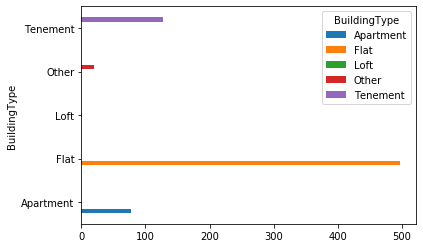

In [87]:
df_sale.groupby(
    'BuildingType')['BuildingType'].value_counts().unstack().plot.barh()

**For Rent:**

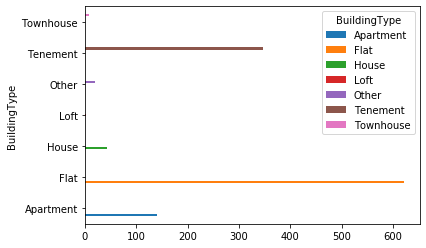

In [88]:
df_rent.groupby(
    'BuildingType')['BuildingType'].value_counts().unstack().plot.barh()

**For analysis I am going to keep 'flats' as currently, I am interested in just with this type of property**

In [89]:
b_type = 'Flat'
df_sale2 = df_sale[df_sale.BuildingType == b_type].copy()
df_rent2 = df_rent[df_rent.BuildingType == b_type].copy()

In [90]:
df_sale2.drop(columns={'BuildingType'}, inplace=True)
df_rent2.drop(columns={'BuildingType'}, inplace=True)

In [91]:
print(f'{len(df_sale2)} - records in "for sale" table \n')
print(f'{len(df_rent2)} - records in "for rent" table')

498 - records in "for sale" table 

621 - records in "for rent" table


In [92]:
df_sale2.head()

,Price,PriceSqM,Bedrooms,Place,Advert_Owner,SqM,Floor,Market,Furnishings,City,District,Negotiating
1,280000.0,3684.21,4,"Rybnik, Śląskie",Private,76.0,1,After,0,Rybnik,Rybnik,1
5,187000.0,4794.87,2,"Rybnik, Śląskie",Developer,39.0,0,After,1,Rybnik,Rybnik,1
12,189000.0,3417.72,3,"Rybnik, Śląskie",Developer,55.3,4,Primary,1,Rybnik,Rybnik,0
16,143000.0,3575.00,2,"Rybnik, Śląskie",Developer,40.0,0,After,0,Rybnik,Rybnik,1
25,280000.0,3684.21,4,"Rybnik, Śląskie",Private,76.0,1,After,0,Rybnik,Rybnik,1


In [93]:
df_rent2.head()

,Bedrooms,Place,Advert_Owner,SqM,Floor,Furnishings,City,District,Negotiating,MonthlyPrice,PriceSqM
3,2,"Rybnik, Śląskie",Developer,50.00,1,1,Rybnik,Rybnik,1,1900.0,38.000000
4,2,"Rybnik, Śląskie",Developer,66.00,4,1,Rybnik,Rybnik,0,2200.0,33.333333
6,1,"Rybnik, Śląskie",Private,45.00,1,1,Rybnik,Rybnik,1,1199.0,26.644444
10,1,"Rybnik, Śląskie",Developer,28.00,1,0,Rybnik,Rybnik,1,980.0,35.000000
15,3,"Rybnik, Śląskie",Developer,62.65,2,1,Rybnik,Rybnik,0,1600.0,25.538707


### Price checking: 
Remove prices which are 3 times higher/lower than a median per city, as I do not want to see flats with custom prices.

In [94]:
from IPython.core.display import display, HTML
import matplotlib
%matplotlib inline

In [95]:
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [96]:
def PriceSqM_loop(tbl):
    for index, rows in tbl.groupby('City')['PriceSqM'].mean().reset_index(
    ).sort_values('PriceSqM').iterrows():
        arr_City.append(rows.City)
        arr_PriceSqM.append(rows.PriceSqM)
    return arr_City, arr_PriceSqM

In [97]:
def PriceSqM_Plot(label1, label2, title_txt):
    index = np.arange(len(label1))
    plt.plot(index, label2)
    plt.rcParams['figure.figsize'] = (12, 8)
    #plt.xlabel('', fontsize=10)
    plt.ylabel('PLN / SQM', fontsize=10)
    plt.xticks(index, label1, fontsize=10, rotation=50)
    plt.title(title_txt)
    plt.show()

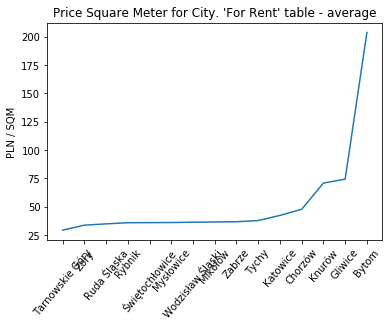

In [98]:
arr_City = []
arr_PriceSqM = []
arr_title = "Price Square Meter for City. 'For Rent' table - average"
PriceSqM_loop(df_rent2)
PriceSqM_Plot(arr_City, arr_PriceSqM, arr_title)

As we can see below, we have some flats which have much bigger price per SqM than the other flats in Bytom

In [99]:
df_rent2[df_rent2.City == 'Bytom'].describe()

,Bedrooms,SqM,Floor,Furnishings,Negotiating,MonthlyPrice,PriceSqM
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,1.651163,35.920930,2.325581,0.744186,0.162791,7968.837209,203.641257
std,0.482243,6.951004,2.337285,0.441481,0.373544,30665.451612,765.666166
min,1.000000,20.000000,0.000000,0.000000,0.000000,770.000000,22.000000
25%,1.000000,32.000000,1.000000,0.500000,0.000000,1100.000000,30.975452
50%,2.000000,37.000000,2.000000,1.000000,0.000000,1200.000000,35.294118
75%,2.000000,39.500000,4.000000,1.000000,0.000000,1475.000000,42.598784
max,2.000000,50.000000,10.000000,1.000000,1.000000,145180.000000,3629.500000


Create a function where price for SQM cannot be higher than 3 times more than median for each city

In [100]:
def avg_price(tbl, city):
    return tbl[tbl.District == city].groupby(
        'District')['PriceSqM'].median().values[0]

In [101]:
df_rent2['avg_price'] = df_rent2.apply(
    lambda x: avg_price(df_rent2, df_rent2['City']) * 3, axis=1)

In [102]:
# This is what we want to remove:
df_rent2[df_rent2.PriceSqM > df_rent2.avg_price]

,Bedrooms,Place,Advert_Owner,SqM,Floor,Furnishings,City,District,Negotiating,MonthlyPrice,PriceSqM,avg_price
311,3,"Chorzów, Śląskie",Private,60.00,2,1,Chorzów,Chorzów,0,20850.0,347.500000,105.882353
339,1,"Chorzów, Śląskie",Developer,36.00,1,1,Chorzów,Chorzów,1,7435.0,206.527778,105.882353
881,3,"Gliwice, Śląskie, Szobiszowice",Developer,58.50,1,1,Gliwice,"Gliwice, Szobiszowice",1,98999.0,1692.290598,105.882353
1207,4,"Zabrze, Śląskie",Developer,8.00,0,1,Zabrze,Zabrze,1,850.0,106.250000,105.882353
1428,2,"Knurów, gliwicki, Śląskie",Developer,52.15,2,1,Knurów,Knurów,0,20935.0,401.438159,105.882353
1538,2,"Bytom, Śląskie",Developer,40.00,1,0,Bytom,Bytom,0,145180.0,3629.500000,105.882353
1556,2,"Bytom, Śląskie",Developer,40.00,1,0,Bytom,Bytom,0,145180.0,3629.500000,105.882353


In [103]:
df_rent3 = df_rent2.drop(
    df_rent2[(df_rent2.PriceSqM > df_rent2.avg_price)].index)

In [104]:
df_rent3.drop(columns={'avg_price'}, inplace=True)

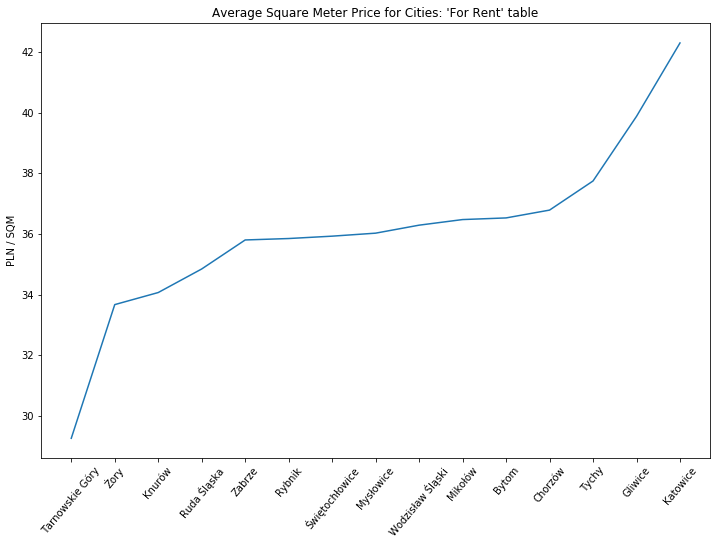

In [105]:
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
arr_City = []
arr_PriceSqM = []
arr_title = "Average Square Meter Price for Cities: 'For Rent' table"
PriceSqM_loop(df_rent3)
PriceSqM_Plot(arr_City, arr_PriceSqM, arr_title)

Now it looks much better

**For Sale**

In [106]:
df_sale2['avg_price'] = df_sale2.apply(
    lambda x: avg_price(df_sale2, df_sale2['City']) * 3, axis=1)

In [107]:
df_sale3 = df_sale2.drop(
    df_sale2[(df_sale2.PriceSqM > df_sale2.avg_price)].index)
df_sale3.drop(columns={'avg_price'}, inplace=True)

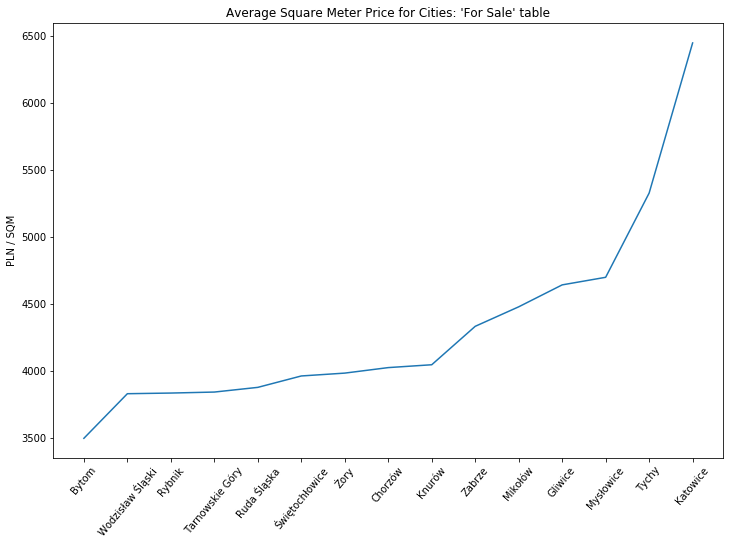

In [108]:
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
arr_City = []
arr_PriceSqM = []
arr_title = "Average Square Meter Price for Cities: 'For Sale' table"
PriceSqM_loop(df_sale3)
PriceSqM_Plot(arr_City, arr_PriceSqM, arr_title)

**The tables with properties, both for sale and for rent are clean and ready for analyzing.**

**Short Conclusions:**

We can see that in three cities we have the highest SQM price no matter is it an offer for sale or for rent. Those cities:

- Tychy, 
- Gliwice 
- Katowice 

In my city (Wodzisław Śląski) buying a flat is more profitable than rent it

## Analysis

### Map with our cities (folium library)
I have created a file with cities and coordinates

In [151]:
location = pd.read_csv(location_list, sep=';', encoding='windows-1250')

In [152]:
location.head(2)

,City,Location
0,Rybnik,"[50.094339, 18.547365]"
1,Chorzów,"[50.296975, 18.957579]"


In [153]:
df_cities = df_sale[['City']].drop_duplicates()

In [154]:
df_cities = df_cities.merge(location, on='City', how='inner')

In [155]:
for column in df_cities.columns:
    df_cities[column] = (df_cities[column].astype("str")
                            .str.replace("ł", "l")
                            .str.replace("Ł", "L")
                            .str.normalize('NFKD')
                            .str.encode('ascii', errors='ignore')
                            .str.decode('utf-8'))

In [163]:
city_list = []
for city in range(len(df_cities)):
    city_list.append(df_cities.iloc[city, 0])
    city_list.append(df_cities.iloc[city, 1])

In [165]:
import folium

In [166]:
map = folium.Map(location=[50.226329, 19.019543], zoom_start=9.4)

In [167]:
def add_location(city,lat,lon):
    tooltip = 'Click for more info'
    folium.Marker([lat,lon],
                  popup='<strong>'+city+'</strong>',
                 tooltip=tooltip).add_to(map)

In [168]:
for x in range(len(city_list)):
    if (x % 2 == 0):
        city = city_list[x]
        loc = city_list[x+1]
        lat = float(loc.strip(',')[1:10])
        lon = float(loc.strip(',')[12:21])
    add_location(city,lat,lon)

In [169]:
map

### Distance between cities

I want to know what will be my cost for traveling depends on my starting point. Of course, Katowice will by my final destination. 

In [170]:
import math

In [171]:
R = 6373.0 # radius of the Earth

Coordinates for Katowice:
> **Warning:** Coordinates must be converted to radians for the calculations to be correct.

In [172]:
kato_lat = float(location[(location.City=='Katowice')].iloc[0,1][1:10])
kato_lon = float(location[(location.City=='Katowice')].iloc[0,1][12:21])

lat1 = math.radians(kato_lat)
lon1 = math.radians(kato_lon)

This function will calculate distances between the cities:

In [173]:
def distance_calc(city):
    city_lat = float(location[(location.City==city)].iloc[0,1][1:10])
    city_lon = float(location[(location.City==city)].iloc[0,1][12:21])

    lat2 = math.radians(city_lat)
    lon2 = math.radians(city_lon)
    
    # change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

A new column with distances:

In [174]:
df1 = location[['City']].copy()

In [175]:
df1['Distance'] = location.apply(lambda x: distance_calc(x.City),axis=1) # from a city to Katowice

In [176]:
df1.head()

,City,Distance
0,Rybnik,39.284325
1,Chorzów,6.703432
2,Tychy,15.546700
3,Mysłowice,7.585523
4,Mikołów,13.157140


**Traveling Cost:**
Now we want to know what will be our average monthly cost for traveling. To do that we need to know some details, such as:

- Petrol price (4,5 PLN)
- Distance (we have it already)
- How many days are we going to travel during a month (~20 * 2 sides)
- An average fuel consumption of my car 
- As the time is the biggest value then we need to calculate it as well. Based on some examples we can say that on average we need 1 min for 1 km   

In [177]:
petrol_price = 4.5 # 4,50 PLN per 1 litre
fuel_consumption = 6 # 6 litres per 100 km
days = 20
sides = 2
rate_per_hr = 45 # 45 PLN per 1 hour
my_sqm = 60 # I need a flat with 60sqm

In [178]:
def travel_cost(distance):
    res = (distance*days*sides)*fuel_consumption/100*petrol_price
    return res

In [179]:
df1['Travel_Time_Cost'] = (df1.Distance/60)*sides*days*rate_per_hr

In [180]:
df1['Travel_Cost'] = df1.apply(lambda x: travel_cost(x.Distance),axis=1)

In [181]:
df1.head()

,City,Distance,Travel_Time_Cost,Travel_Cost
0,Rybnik,39.284325,1178.529737,424.270705
1,Chorzów,6.703432,201.102959,72.397065
2,Tychy,15.546700,466.401003,167.904361
3,Mysłowice,7.585523,227.565695,81.923650
4,Mikołów,13.157140,394.714210,142.097116


In [182]:
df1['Travel_Cost'] = df1.Travel_Cost+df1.Travel_Time_Cost

In [183]:
df1 = df1.merge(df_sale3.groupby('City')['PriceSqM'].mean().reset_index(),on='City',how='inner')
df1.rename(columns={'PriceSqM':'PriceSqM_Sale'},inplace=True)

In [184]:
df1 = df1.merge(df_rent3.groupby('City')['PriceSqM'].mean().reset_index(),on='City',how='inner')
df1.rename(columns={'PriceSqM':'PriceSqM_Rent'},inplace=True)

In [185]:
df1.drop(columns={'Distance','Travel_Time_Cost'},inplace=True)

Here we have monthly costs for travel from a city to Katowice, average price for 1 SQM for sale and for rent per each city 

In [186]:
df1

,City,Travel_Cost,PriceSqM_Sale,PriceSqM_Rent
0,Rybnik,1602.800442,3834.843778,35.847038
1,Chorzów,273.500024,4025.019545,36.783957
2,Tychy,634.305364,5329.243409,37.744069
3,Mysłowice,309.489345,4699.836250,36.023960
4,Mikołów,536.811326,4479.228889,36.472052
5,Tarnowskie Góry,1069.858980,3842.281111,29.262273
6,Gliwice,1177.349716,4643.191667,39.873572
7,Zabrze,721.737139,4333.499592,35.799860
8,Ruda Śląska,463.394309,3877.360000,34.843764
9,Knurów,1066.279361,4046.322000,34.066715


### Profitability calculation
Check in which city buying a flat has the biggest sense due to profitability

**For Sale:**

In [187]:
def profit_calc():
    d=pd.concat(
        [(((df1[df1.City=='Katowice'].iloc[0,2])*my_sqm-
                 (df1['PriceSqM_Sale']*my_sqm))/df1.Travel_Cost/12)
               .to_frame(name="Profitability"),df1],axis=1
    )[['City','Profitability']].sort_values('Profitability')
    d = d[d.City!='Katowice'] # we do not need Katowice as it is our destination
    return d

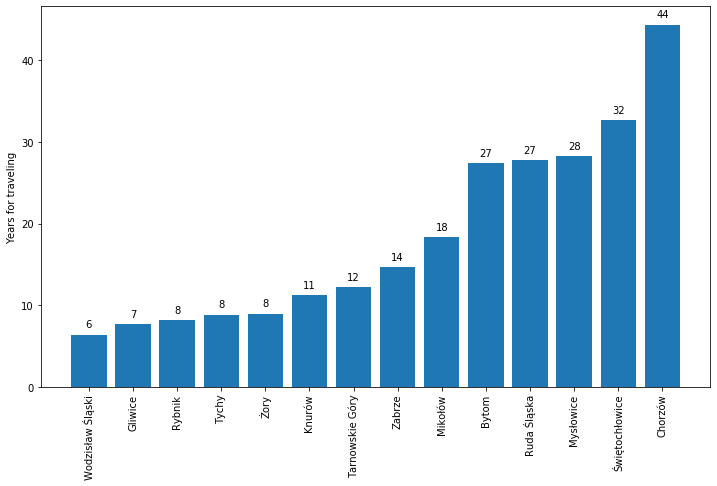

In [188]:
x = profit_calc().City.values #(for_rent,for_sale) <-choose just one True
y = profit_calc().Profitability.values

fig, ax = plt.subplots(figsize=(12, 7))
plt.bar(x, y)

for p in ax.patches:
    ax.annotate(np.round(p.get_height().astype(int)),
                (p.get_x()+p.get_width()/2,
                 p.get_height()),
                xytext=(0, 10),
                textcoords="offset points",
               ha='center',
               va='center')
plt.ylabel('Years for traveling')  
plt.xticks(x, rotation='vertical')

plt.show()

The columns show how much time do we need for driving to Katowice from the chosen city. So, the bigger value we have in profitability column the better place it is to live there:

- due to close situated place between the chosen city and Katowice or/and
- much cheaper price for a flat

**Short explanation of what we can see in the above table:**
>Costs difference between 60 SQM flats in Katowice and Wodzisław will be covered within 6 years of traveling to work in Katowice. So there is no point to travel and it is much better for me to buy a flat in Katowice

>Distance between Chorzów and Katowice is so small and average price for a flat is big enough that there is better option for me to find a flat in Chorzów as we need around 33 years of daily traveling to Katowice to cover difference between both properties

**For Rent:**

In [189]:
kato_rent = "{:.0f}".format(df1[df1.City=='Katowice'].iloc[0,3]*my_sqm)
tarn_rent = "{:.0f}".format(df1[df1.City=='Tarnowskie Góry'].iloc[0,3]*my_sqm)
tarn_trav = "{:.0f}".format(df1[df1.City=='Tarnowskie Góry'].iloc[0,1])

print(f"Monthly rental cost including the rent:\n\
- Katowice: {kato_rent} PLN\n\
- Tarnowskie Góry: {tarn_rent} PLN\n\
- Difference: {'{:.0f}'.format(float(kato_rent)-float(tarn_rent))} PLN\n\
- Travel to Katowice from Tarnowskie Góry: {'{:.0f}'.format(df1[df1.City=='Tarnowskie Góry'].iloc[0,1])} PLN\n\n\
The cost for travel is higher than difference due to rental costs.\n\
So, if we want to rent a flat, then it is much better to do it in Katowice")

Monthly rental cost including the rent:
- Katowice: 2538 PLN
- Tarnowskie Góry: 1756 PLN
- Difference: 782 PLN
- Travel to Katowice from Tarnowskie Góry: 1070 PLN

The cost for travel is higher than difference due to rental costs.
So, if we want to rent a flat, then it is much better to do it in Katowice


### Summary:


**Comments about the analysis**
* I am aware that the property price is changing and the differences between other cities/district might be changed
* Distances have been calculated based on coordinates from random (usually centre) place in the cities. If I would choose exact coordinates for each of the districts then the distance will be a bit different
* Time for traveling (1min=1km) was calculated based on average time I have checked on google maps. There is a possibility to import "gmaps" library and calculate much precise time for each city

As the aim of this project was to download data from websites about properties in chosen cities and check how prices of flats look like and where is the best place to live for me if our main 2 features will be price of a property and time for travel between flat and a work place in Katowice.

Now I know that if I would look for a place to live, then the most profitable options would be one of the city between Mysłowice, Bytom, Mikołów, Ruda Śląska, Świętochłowice and Chorzów. There we have relatively cheap properties (in comparison to Katowice) and still it is not far from my future work place :) 

**How about "For Rent" properties?:**

In case of the "rent table" we could see that the price differences between all cities are not significant and if I would like to rent a flat, there the best option would be to do it in the city where I am going to work (as close as possible to a work place)